# Trees - Modelling

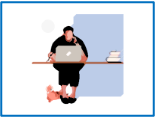

## PROBLEM: With given dataset, predict the probability of the payment within 90 days!

This is a small sample of data (both in terms of observations and available variables) that is actually used for training our models in *****. All the IDs are replaced, and all datapoints have a slight noise added to them to avoid any chance of identification. Data is stored as a small SQLite database stored in attached `session_11.db` file. There are two tables - `dataset` and `metadata`. The data sample spans 1 year and 30k observations.

In [1]:
import sqlite3
import pandas as pd
con = sqlite3.connect('session_11.db')

df_metadata = pd.read_sql_query('SELECT * FROM metadata;', con)
df_metadata

,varcode,name,var_class,entity_table
0,a8404,RatioOfCustomersAtAddressWithSuccessfullyClose...,variable,address
1,ap090,TargetAmount90Days,target,case
2,c0001,OriginalCapitalOfCaseInvoices,variable,case
3,c0015,AmountOfCase,variable,case
4,c0019,AgeOfDebt,variable,case
5,c0031,NumberOfTelephonesCI,variable,case
6,c0039,IndustryCode,variable,case
7,c0044,ClientName,variable,case
8,c9008,CustomerAge,variable,case
9,ct090,Target90Days,target,case


### Some background information on the data

The intended target for prediction is `ct090`, `case_id` is the unique identifier, `keydate` is the point in time when some event has happened in the lifecycle of a case, and also a date relative to which all of the backward looking variables and forward looking targets are calculated. In this case, it's a general purpose propensity to pay model, which means that it is a freshly registered case, where all the relevant data has been gathered and verified. In other words, `keydate` is set a few days after registration, and target `ct090` is checking for outcome in 90 days (`ap090` is a similar regression target), while all the rest of the data is only looking backwards!

Metadata gives some basic description of variables. The general naming convention is based on prefixes that define aggregation levels - `cXXXX` looking at the data of this case only, `dXXXX` looking at other cases of same debtor, `bXXXX` looking at all cases of the debtor, `aXXXX` looking at all the cases on the same address. This is not very relevant for this particular task, but gives some idea of our data setup here in ******! Note that this data selection has quite a few variables with the `dXXXX` prefix, which means that this selection is specifically looking at debtors that we already had worked with before, therefore, variable selection is much broader and models are generally better. 

One more tip on interpretation of missing values: if variable is bound by time window, e.g. `d2112 NumberOfCustomerPaymentsInLast12Months`, the `NA` value implies that there never have been any values, while `0` would mean that have been no values within bounding period (in this case 12 months). In other words, `0` and `NA` have different interpretation. It may or may not be relevant, depending on the choice of the modelling approach. 

### Some tips on the task

There is no end to seeking the perfection, and countless ways to approach this task. However, try not to approach this like a competition to crank out the highest possible accuracy metrics. What matters is the sequence and thought process - show this in illustrations and comments! Even if certain things might take too long to implement in a code, but you have a good idea where to go with this - write down your ideas! This is what matters.

Good luck!

### First look at the data

In [2]:
#Import some necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [3]:
#Taking a look at the metadata table to understand the dataset table
df_metadata = pd.read_sql_query('SELECT * FROM metadata;', con)
df_metadata

,varcode,name,var_class,entity_table
0,a8404,RatioOfCustomersAtAddressWithSuccessfullyClose...,variable,address
1,ap090,TargetAmount90Days,target,case
2,c0001,OriginalCapitalOfCaseInvoices,variable,case
3,c0015,AmountOfCase,variable,case
4,c0019,AgeOfDebt,variable,case
5,c0031,NumberOfTelephonesCI,variable,case
6,c0039,IndustryCode,variable,case
7,c0044,ClientName,variable,case
8,c9008,CustomerAge,variable,case
9,ct090,Target90Days,target,case


In [4]:
#Now lets take a look at the dataset table
df_dataset = pd.read_sql_query('SELECT * FROM dataset;', con)
df_dataset

,case_id,keydate,ct090,ap090,c0001,c0039,c0044,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d0012,d1205,c0015
0,1,2017-08-12 00:00:00.0,0.0,0.0,221.68,K6622,1,2.0,0.00,238.38,2.0,NaN,98.0,0.0,49.0,0.0,1,NaN,222.69
1,2,2017-02-03 00:00:00.0,0.0,0.0,151.36,K6512,2,NaN,210.53,0.00,5.0,NaN,109.0,2.0,51.0,0.0,2,1.0,212.72
2,3,2017-02-17 00:00:00.0,0.0,0.0,48.84,K6512,3,1.0,NaN,0.00,2.0,0.00,748.0,0.0,48.0,NaN,3,NaN,56.84
3,4,2017-09-18 00:00:00.0,0.0,0.0,413.15,K6622,4,NaN,NaN,54.14,3.0,1.00,8.0,0.0,27.0,NaN,4,NaN,463.15
4,5,2017-07-22 00:00:00.0,0.0,0.0,125.83,K6512,5,2.0,20.00,83.00,6.0,NaN,324.0,0.0,40.0,0.0,1,NaN,146.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,2017-05-22 00:00:00.0,0.0,0.0,435.46,K6512,27,NaN,978.62,242.06,3.0,1.00,4.0,0.0,40.0,3.0,7,1.0,435.46
29996,29997,2017-08-20 00:00:00.0,1.0,188.4,344.07,K6512,10,NaN,NaN,25408.75,2.0,0.27,111.0,1.0,40.0,NaN,4,NaN,372.48
29997,29998,2017-06-11 00:00:00.0,0.0,0.0,417.23,K6512,6,1.0,NaN,0.00,3.0,0.09,103.0,0.0,41.0,NaN,1,NaN,516.45
29998,29999,2017-02-17 00:00:00.0,0.0,0.0,529.00,K6512,11,NaN,101.90,0.00,2.0,NaN,199.0,0.0,54.0,0.0,6,1.0,544.00


It seems like the dataset contains a mix of numerical and categorical variables from various tables (case, debtor, address, debtor_oc) that can be used to predict the probability of payment within 90 days. Some examples of predictor variables include 'OriginalCapitalOfCaseInvoices', 'AgeOfDebt', 'NumberOfTelephonesCI', 'IndustryCode', 'ClientName', 'CustomerAge', 'AmountOfCustomerPaymentsOnAllCasesBlevel', 'NumberOfSuccessfullyClosedCasesInLast24Months', 'NumberOfCustomerPaymentsInLast12Months', etc.

It might be useful to perform feature engineering on some of these variables to extract more information and improve their predictive power. Additionally, the missing values in these variables might need to be handled properly before they can be used for modeling.


### Implement an Exploratory Data Analysis (EDA) and draw some practical and business conclusions

In [5]:
df_dataset.shape

(30000, 19)

In [6]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   case_id  30000 non-null  int64  
 1   keydate  30000 non-null  object 
 2   ct090    30000 non-null  float64
 3   ap090    30000 non-null  float64
 4   c0001    29975 non-null  float64
 5   c0039    30000 non-null  object 
 6   c0044    30000 non-null  object 
 7   d0031    17371 non-null  float64
 8   b0007    13074 non-null  float64
 9   d0009    30000 non-null  float64
 10  c0031    30000 non-null  float64
 11  a8404    19599 non-null  float64
 12  c0019    30000 non-null  float64
 13  d0027    30000 non-null  float64
 14  c9008    27016 non-null  float64
 15  d2112    13048 non-null  float64
 16  d0012    30000 non-null  object 
 17  d1205    8762 non-null   float64
 18  c0015    30000 non-null  float64
dtypes: float64(14), int64(1), object(4)
memory usage: 4.3+ MB


As we can see, we are going to have to deal with 'keydate', 'c0039', and 'c0044' since they are categorical attributes.

In [7]:
df_dataset.describe()

,case_id,ct090,ap090,c0001,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d1205,c0015
count,30000.000000,30000.000000,30000.000000,29975.000000,17371.000000,13074.000000,30000.000000,30000.000000,19599.000000,30000.000000,30000.000000,27016.000000,13048.000000,8762.000000,30000.000000
mean,15000.500000,0.168733,49.215836,538.590694,1.634391,423.156043,555.063823,3.092900,0.283395,104.948833,0.473067,42.339466,0.935622,0.897170,605.535361
std,8660.398374,0.374522,240.063401,1248.533877,1.318419,902.166491,1939.588574,2.151021,0.312366,196.864753,1.397094,13.215883,1.755761,0.814515,1223.783876
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-319.010000,0.000000,0.000000,3.000000,0.000000,6.000000,0.000000,0.000000,9.750000
25%,7500.750000,0.000000,0.000000,145.100000,1.000000,76.000000,0.000000,2.000000,0.000000,10.000000,0.000000,32.000000,0.000000,0.000000,185.410000
50%,15000.500000,0.000000,0.000000,298.720000,1.000000,202.715000,0.000000,3.000000,0.210000,77.000000,0.000000,41.000000,0.000000,1.000000,355.650000
75%,22500.250000,0.000000,0.000000,638.645000,2.000000,500.677500,481.322500,4.000000,0.450000,126.000000,0.000000,51.000000,1.000000,1.000000,725.480000
max,30000.000000,1.000000,25000.000000,84561.840000,15.000000,53982.610000,110158.640000,35.000000,1.000000,6193.000000,40.000000,117.000000,24.000000,15.000000,84561.840000


In [8]:
#Checking for missing values:
df_dataset.isnull().sum()

case_id        0
keydate        0
ct090          0
ap090          0
c0001         25
c0039          0
c0044          0
d0031      12629
b0007      16926
d0009          0
c0031          0
a8404      10401
c0019          0
d0027          0
c9008       2984
d2112      16952
d0012          0
d1205      21238
c0015          0
dtype: int64

As we can see, there are a lot of missing values, so we will deal with them in the next section

To get some business and practical conclusions, lets play around with the dataset:

In [9]:
# Get the average amount of debt for each industry
industry_avg_debt = df_dataset.groupby('c0039')['c0015'].mean()
print('Average amount of debt for each industry:')
industry_avg_debt

Average amount of debt for each industry:


c0039
K6419    2016.383201
K6420     414.400000
K6491    1394.364167
K6499     833.101854
K6511     191.748333
K6512     573.586057
K6619     304.090208
K6622     563.544094
Name: c0015, dtype: float64

In [10]:
# Get the number of cases per client
client_case_counts = df_dataset['c0044'].value_counts()
print('Number of cases per client:')
client_case_counts

Number of cases per client:


6      3126
12     3064
2      2738
10     2717
11     1109
       ... 
167       1
96        1
156       1
158       1
181       1
Name: c0044, Length: 181, dtype: int64

In [11]:
#Average age of cases:
avg_age_of_cases = df_dataset['c0019'].mean()
print(f"The average age of cases is {round(avg_age_of_cases, 2)} days.")

The average age of cases is 104.95 days.


In [12]:
corr_matrix = df_dataset.corr()
target_corr = corr_matrix['ct090'].sort_values(ascending=False)
corr_matrix

,case_id,ct090,ap090,c0001,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d1205,c0015
case_id,1.000000,-0.003711,-0.001686,-0.002852,0.007377,-0.010315,0.006311,0.004048,-0.005631,-0.005460,0.002852,0.004011,0.009185,0.011437,-0.003173
ct090,-0.003711,1.000000,0.455047,-0.029447,-0.091434,0.020335,-0.051487,-0.085084,0.080214,0.013104,0.064621,0.056772,0.032500,0.052090,-0.027784
ap090,-0.001686,0.455047,1.000000,0.149193,-0.032596,0.044846,-0.012150,-0.042510,0.042176,0.005786,0.024020,0.031471,0.036292,0.024966,0.158048
c0001,-0.002852,-0.029447,0.149193,1.000000,0.008446,0.044809,0.059502,0.017770,0.005475,0.221894,-0.000576,-0.005328,0.005004,0.011489,0.955115
d0031,0.007377,-0.091434,-0.032596,0.008446,1.000000,-0.011586,0.130782,0.411012,-0.060576,-0.020024,0.085047,-0.011885,-0.016554,-0.017319,0.011663
b0007,-0.010315,0.020335,0.044846,0.044809,-0.011586,1.000000,0.081183,0.059494,0.054159,0.039448,0.160658,0.061797,0.190976,0.162209,0.051354
d0009,0.006311,-0.051487,-0.012150,0.059502,0.130782,0.081183,1.000000,0.169996,-0.009075,-0.012308,0.052850,0.033961,0.106597,-0.020142,0.063671
c0031,0.004048,-0.085084,-0.042510,0.017770,0.411012,0.059494,0.169996,1.000000,-0.060652,-0.035520,0.156131,0.038422,0.018640,-0.030617,0.025271
a8404,-0.005631,0.080214,0.042176,0.005475,-0.060576,0.054159,-0.009075,-0.060652,1.000000,0.023477,0.020312,0.046922,-0.003489,0.049618,0.000770
c0019,-0.005460,0.013104,0.005786,0.221894,-0.020024,0.039448,-0.012308,-0.035520,0.023477,1.000000,-0.006182,0.000244,-0.001772,0.016808,0.210471


In [13]:
target_corr

ct090      1.000000
ap090      0.455047
a8404      0.080214
d0027      0.064621
c9008      0.056772
d1205      0.052090
d2112      0.032500
b0007      0.020335
c0019      0.013104
case_id   -0.003711
c0015     -0.027784
c0001     -0.029447
d0009     -0.051487
c0031     -0.085084
d0031     -0.091434
Name: ct090, dtype: float64

It doesnt seem like attributes are very correlated to the target, in fact, the most correlated is the second target value.

### Work with missing values and draw some conclusions

In [14]:
df_dataset.isnull().sum()

case_id        0
keydate        0
ct090          0
ap090          0
c0001         25
c0039          0
c0044          0
d0031      12629
b0007      16926
d0009          0
c0031          0
a8404      10401
c0019          0
d0027          0
c9008       2984
d2112      16952
d0012          0
d1205      21238
c0015          0
dtype: int64

Since some attributes have so many missing values, "d1205", "d2112" and "b0007" will be dropped.

In [15]:
df_dataset.drop('d1205', axis = 1, inplace = True)
df_dataset.drop('d2112', axis = 1, inplace = True)
df_dataset.drop('b0007', axis = 1, inplace = True)

It might be a good idea to drop columns with more than 30% missing values, but I will try to deal with the rest of the data

In [16]:
#c0001 only has 25 missing values
mean_value = df_dataset["c0001"].mean()
df_dataset["c0001"].fillna(mean_value, inplace=True)

In [17]:
#d0031 - I want to see what the values d0031 has before I decide how to deal with the data:
value_counts = df_dataset['d0031'].value_counts()
value_counts

1.0     9502
2.0     3588
3.0     1510
0.0     1339
4.0      728
5.0      347
6.0      166
7.0       94
8.0       49
9.0       22
10.0      10
11.0       8
13.0       3
12.0       3
14.0       1
15.0       1
Name: d0031, dtype: int64

In [18]:
# replace missing values in d0031 with mode
mode_data = df_dataset['d0031'].mode()[0]  # calculate mode of column A
df_dataset['d0031'].fillna(mode_data, inplace=True)

In [19]:
#a8404 - I want to see what the values a8404 has before I decide how to deal with the data:
value_counts = df_dataset['a8404'].value_counts()
value_counts

0.00    7095
1.00    1987
0.50    1650
0.33    1210
0.25     890
        ... 
0.78       2
0.76       1
0.67       1
0.73       1
0.81       1
Name: a8404, Length: 84, dtype: int64

In [20]:
#After checking the values it seems like I can use the mean to deal with the missind values of these:
#a8404
mean_value = df_dataset["a8404"].mean()
df_dataset["a8404"].fillna(mean_value, inplace=True)

#c9008
mean_value = df_dataset["c9008"].mean()
df_dataset["c9008"].fillna(mean_value, inplace=True)

In [21]:
df_dataset.isnull().sum()

case_id    0
keydate    0
ct090      0
ap090      0
c0001      0
c0039      0
c0044      0
d0031      0
d0009      0
c0031      0
a8404      0
c0019      0
d0027      0
c9008      0
d0012      0
c0015      0
dtype: int64

### Feature engineering

In [22]:
df_dataset

,case_id,keydate,ct090,ap090,c0001,c0039,c0044,d0031,d0009,c0031,a8404,c0019,d0027,c9008,d0012,c0015
0,1,2017-08-12 00:00:00.0,0.0,0.0,221.68,K6622,1,2.0,238.38,2.0,0.283395,98.0,0.0,49.0,1,222.69
1,2,2017-02-03 00:00:00.0,0.0,0.0,151.36,K6512,2,1.0,0.00,5.0,0.283395,109.0,2.0,51.0,2,212.72
2,3,2017-02-17 00:00:00.0,0.0,0.0,48.84,K6512,3,1.0,0.00,2.0,0.000000,748.0,0.0,48.0,3,56.84
3,4,2017-09-18 00:00:00.0,0.0,0.0,413.15,K6622,4,1.0,54.14,3.0,1.000000,8.0,0.0,27.0,4,463.15
4,5,2017-07-22 00:00:00.0,0.0,0.0,125.83,K6512,5,2.0,83.00,6.0,0.283395,324.0,0.0,40.0,1,146.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,2017-05-22 00:00:00.0,0.0,0.0,435.46,K6512,27,1.0,242.06,3.0,1.000000,4.0,0.0,40.0,7,435.46
29996,29997,2017-08-20 00:00:00.0,1.0,188.4,344.07,K6512,10,1.0,25408.75,2.0,0.270000,111.0,1.0,40.0,4,372.48
29997,29998,2017-06-11 00:00:00.0,0.0,0.0,417.23,K6512,6,1.0,0.00,3.0,0.090000,103.0,0.0,41.0,1,516.45
29998,29999,2017-02-17 00:00:00.0,0.0,0.0,529.00,K6512,11,1.0,0.00,2.0,0.283395,199.0,0.0,54.0,6,544.00


We cant run models if we have categorical values in the dataset:

In [23]:
#c0039's data is industry codes, and keydates is also not valid
value_counts = df_dataset['c0039'].value_counts()
value_counts

K6512    17329
K6622     9916
K6619     1391
K6419      909
K6499      410
K6491       24
K6420       15
K6511        6
Name: c0039, dtype: int64

In [24]:
code_mode = df_dataset['c0039'].mode()[0]
df_dataset['c0039'].fillna(code_mode, inplace=True)

date_mode = df_dataset['keydate'].mode()[0]
df_dataset['keydate'].fillna(date_mode, inplace=True)

In [25]:
#Outliers
df_dataset = df_dataset[(np.abs(df_dataset.ct090 - df_dataset.ct090.mean()) <= (3 * df_dataset.ct090.std()))]

#Encoder
encoder=LabelEncoder()
df_dataset['c0039'] = encoder.fit_transform(df_dataset['c0039'])
df_dataset['keydate'] = encoder.fit_transform(df_dataset['keydate'])

In [27]:
# Split the data into features and target variable
X = df_dataset.drop('ct090', axis=1)
y = df_dataset['ct090']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the  model
decision = DecisionTreeClassifier(random_state=42)
decision.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = decision.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.999


In [27]:
# Split the data into features and target variable
X = df_dataset.drop('ct090', axis=1)
y = df_dataset['ct090']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
gradient_model = GradientBoostingClassifier(random_state=42)
gradient_model.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = gradient_model.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9991666666666666


### Modeling: solve the problem and compare several models

* Random Forest
* Gradient Boosting
* XGBoost
* LightGMB
* Others